In [17]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle

In [18]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [19]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [20]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [57]:
market.connect()
sec.connect()
db.cloud_connect()
factors_df = []
for row in tqdm(sp500.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("filings",{"cik":cik}))
        filings["year"] = [x.year for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["year"] = filings["year"] + 1
        price = price.merge(filings,on=["year","quarter"]).groupby(["year","quarter"]) \
                        .agg({"assets":"mean","liabilities":"mean","adjclose":"mean"}).reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-1)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
db.disconnect()
factors_df = pd.concat(factors_df)

358it [00:05, 68.27it/s]

NXPI 'date'


422it [00:06, 69.58it/s]

STX 'date'


451it [00:06, 69.56it/s]

TEL 'date'


503it [00:07, 66.09it/s]


In [58]:
model = XGBRegressor()
factors = ["assets","liabilities"]
factors_df.sort_values(["year","quarter"],inplace=True)
training_data = factors_df[factors_df["year"]<2024].dropna()
sim = factors_df[factors_df["year"]==2024].drop("y",axis=1).dropna()
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

In [74]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sub-Industry"]],on="ticker",how="left")
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["historical_return"] = price["adjclose"].pct_change(90)
        price["factor_return"] = price["spy"].pct_change(90)
        price["cov"] = price["factor_return"].rolling(100).cov(price["historical_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["historical_return"] - price["rf"])
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 355/503 [00:14<00:05, 26.21it/s]

NXPI 'date'


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 416/503 [00:17<00:03, 26.02it/s]

STX 'date'


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 444/503 [00:18<00:02, 25.89it/s]

TEL 'date'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:20<00:00, 24.09it/s]


In [75]:
price

,date,adjclose,adjlow,adjhigh,volume,ticker,year,quarter,prediction,spy,rf,GICS Sub-Industry,expected_return,historical_return,factor_return,cov,var,beta,excess_return
0,2022-09-12,166.35,164.350,167.210,2434276,ZTS,2022,3,NaN,4110.41,0.0337,Pharmaceuticals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-13,160.99,160.430,163.490,2631206,ZTS,2022,3,NaN,3932.69,0.0342,Pharmaceuticals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-14,160.23,159.285,161.705,2114114,ZTS,2022,3,NaN,3946.01,0.0341,Pharmaceuticals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-15,159.18,158.710,161.690,2101286,ZTS,2022,3,NaN,3901.35,0.0345,Pharmaceuticals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-16,157.30,155.310,158.960,3536894,ZTS,2022,3,NaN,3873.33,0.0345,Pharmaceuticals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10614,2024-09-11,189.99,186.440,191.150,1387932,ZTS,2024,3,254.061508,NaN,NaN,Pharmaceuticals,0.337236,-0.007159,0.0,-0.0,0.0,NaN,NaN
10615,2024-09-11,189.99,186.440,191.150,1387932,ZTS,2024,3,254.061508,NaN,NaN,Pharmaceuticals,0.337236,-0.007159,0.0,-0.0,0.0,NaN,NaN
10616,2024-09-11,189.99,186.440,191.150,1387932,ZTS,2024,3,254.061508,NaN,NaN,Pharmaceuticals,0.337236,-0.007159,0.0,0.0,0.0,NaN,NaN
10617,2024-09-11,189.99,186.440,191.150,1387932,ZTS,2024,3,254.061508,NaN,NaN,Pharmaceuticals,0.337236,-0.007159,0.0,0.0,0.0,NaN,NaN


In [76]:
sim = pd.concat(prices)
sim = sim[sim["date"]>datetime(2024,1,1)]
sim["quarter"] = [x.quarter for x in sim["date"]]

In [101]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
        }
        for _ in sp500["GICS Sub-Industry"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    prev_quarter = quarter
    quarter = date.quarter
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(125):
                position = positions[i]
                sector = list(sp500["GICS Sub-Industry"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(125):
                position = positions[i]
                sector = list(sp500["GICS Sub-Industry"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        notional = stock["pv"]
                        hpr = int((date - stock["buy_date"]).days)
                        opportunity_row = today[today["GICS Sub-Industry"] == sector].sort_values("excess_return", ascending=False).iloc[-j]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (hpr > 90):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional)
                            position["stocks"][j] = stock
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(125):
                    notional = float(cash / 125 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sub-Industry"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today[today["GICS Sub-Industry"] == sector].sort_values("excess_return", ascending=False).iloc[-j]
                        stock = Stock.buy(row, stock, notional)
                        position["stocks"][j] = stock
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

Error on date 2024-01-02 00:00:00: single positional indexer is out-of-bounds


In [102]:
portfolios = []
for state in states:
    for i in range(125):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [103]:
portfolios[0]

{'ticker': 'MMM',
 'adjclose': 107.79,
 'quantity': 7.2727272727272725,
 'excess_return': 0.2670584597869203,
 'buy_price': 110.0,
 'buy_date': Timestamp('2024-01-02 00:00:00'),
 'sell_date': Timestamp('2024-01-02 00:00:00'),
 'pv': 783.9272727272728,
 'date': Timestamp('2024-01-03 00:00:00')}

In [104]:
performance = pd.DataFrame(portfolios).dropna()
performance = performance.groupby("date").agg({"pv":"sum"}).reset_index()
performance["stock_return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

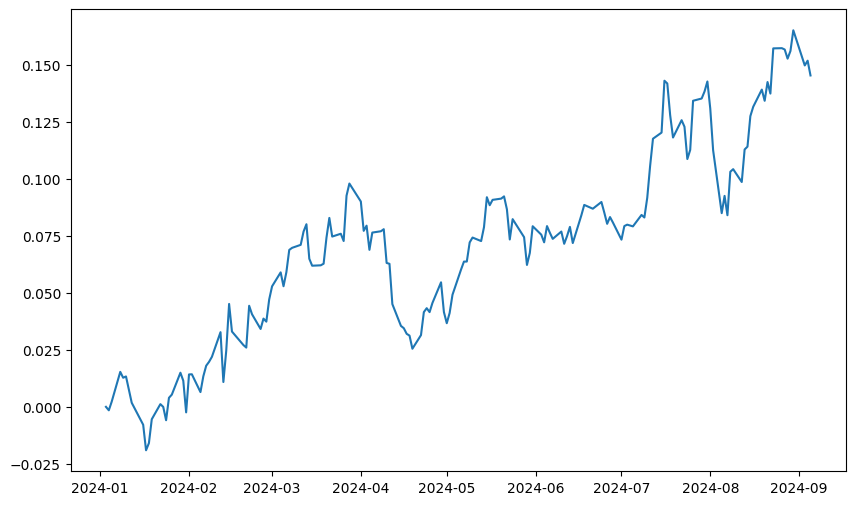

In [105]:
plt.figure(figsize=(10, 6))  
plt.plot(performance["date"].values,performance["stock_return"].values)

In [106]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [107]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

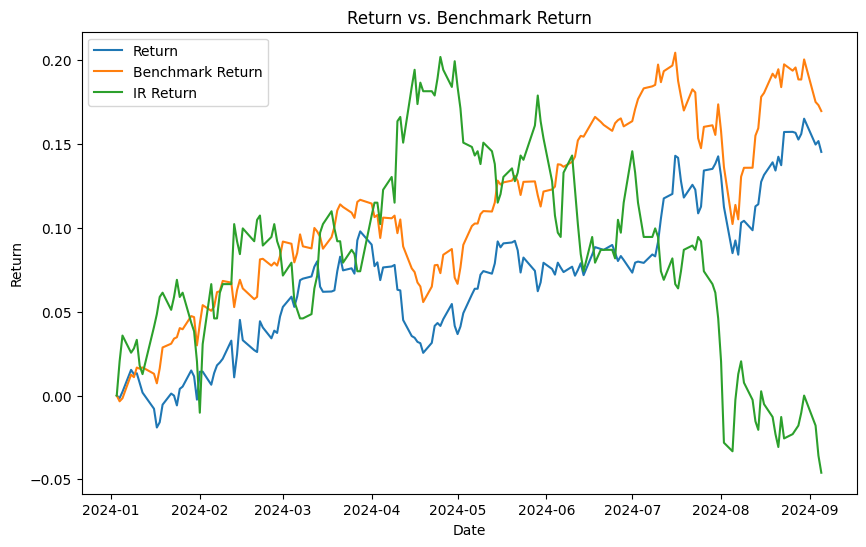

In [108]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [109]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

-0.5651348719536748

In [110]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sub-Industry"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [111]:
t.sort_values("return",ascending=False).head(10)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,GICS Sub-Industry,return,hpr
33,SMCI,1009.91,2.802592,0.241597,285.45,2024-01-02,2024-04-02,2830.366089,"Technology Hardware, Storage & Peripherals",2.537958,91
182,TSLA,231.26,5.978347,1.224770,166.63,2024-04-02,2024-07-02,1382.552559,Automobile Manufacturers,0.387865,91
76,DECK,903.30,1.186979,-0.146784,673.98,2024-01-02,2024-04-02,1072.197988,Footwear,0.340247,91
74,CRWD,319.55,3.240309,0.116220,246.89,2024-01-02,2024-04-02,1035.440885,Systems Software,0.294301,91
66,CMG,58.04,17.817372,0.044463,44.90,2024-01-02,2024-04-02,1034.120267,Restaurants,0.292650,91
68,DVA,135.04,7.484330,-0.093698,106.89,2024-01-02,2024-04-02,1010.683881,Health Care Services,0.263355,91
37,JNPR,36.91,27.266530,0.049599,29.34,2024-01-02,2024-04-02,1006.407635,Communications Equipment,0.258010,91
50,CTLT,56.45,17.758047,0.030218,45.05,2024-01-02,2024-04-02,1002.441731,Pharmaceuticals,0.253052,91
89,GM,44.89,22.191401,-0.095520,36.05,2024-01-02,2024-04-02,996.171983,Automobile Manufacturers,0.245215,91
99,AVGO,165.75,6.420398,0.024231,133.88,2024-04-02,2024-07-02,1064.181005,Semiconductors,0.238049,91


In [112]:
t.groupby(["GICS Sub-Industry"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return").tail(50)

,GICS Sub-Industry,return,hpr
48,Insurance Brokers,0.006376,91.0
76,Reinsurance,0.013455,91.0
40,"Hotels, Resorts & Cruise Lines",0.014841,91.0
83,Soft Drinks & Non-alcoholic Beverages,0.015655,91.0
49,Integrated Oil & Gas,0.015678,91.0
75,Regional Banks,0.016198,91.0
81,Semiconductor Materials & Equipment,0.016904,91.0
90,Trading Companies & Distributors,0.021208,91.0
38,Health Care Supplies,0.021336,91.0
4,Application Software,0.024732,91.0
